In [88]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import random
from torch.utils.data import DataLoader
from torch import nn
import torch
from tqdm.auto import tqdm

In [89]:
train_data = datasets.FashionMNIST(root="image", #資料放在名為image的這個資料夾
                                   train=True, #得到訓練資料
                                   download=True,
                                   transform=ToTensor()) #將圖片轉換成張量形式表達(用來訓練)

test_data = datasets.FashionMNIST(root="image",
                                  train=False, #得到測試資料
                                  download=True,
                                  transform=ToTensor()) #將圖片轉換成張量形式表達(用來訓練)

In [4]:
img, label = train_data[0] #看第一章圖片的內容
class_names = train_data.classes #列出所有圖像類別
class_names[label] #第一章圖片的類別
img.shape #灰階 28*28 pixels

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

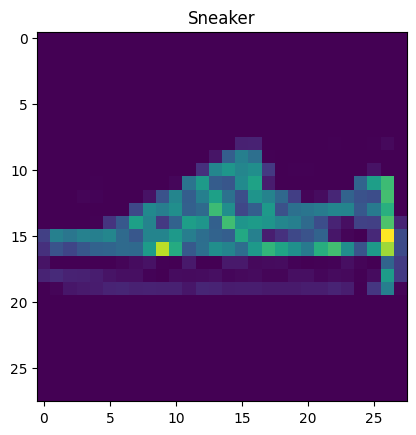

In [5]:
random_idx = random.randint(0, len(train_data)-1)#0~31 不包含32
img, label = train_data[random_idx]
plt.imshow(img.permute(1,2,0)) 
#因為matplotlib預設傳入圖像資訊應該把channel放在最後一個維度
#新的第0/1/2個維度設定維舊的第1/2/0個維度
#色彩是自動加上去的
plt.title(class_names[label])

### 分批資料量
當資料量過大時，原先看過所有資料更新一次參數的方法已經不堪使用(計算量過大)。

In [90]:
len(train_data), len(test_data)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True) #shuffle用於打亂資料增加隨機性

test_dataloader = DataLoader(test_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False) #測試資料不用打亂

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [7]:
x_first_batch, y_first_batch = next(iter(train_dataloader))
#train_dataloader是一個可迭代之物件(像在迴圈中可以一一列出的內容) 
#回傳兩個值 第一個是圖片的向量資料 第二個是圖片的標記(類別)
x_first_batch.shape, y_first_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Dress')

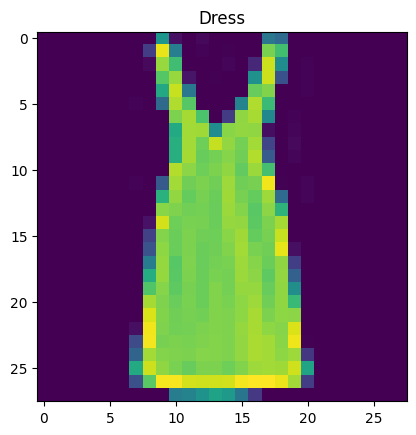

In [8]:
#從batch中隨機取值產生圖片
random_idx = random.randint(0, len(x_first_batch)-1)#0~31 不包含32
img, label = x_first_batch[random_idx], y_first_batch[random_idx]
plt.imshow(img.permute(1,2,0)) 
plt.title(class_names[label])

### 特徵攤平
將圖片的多維向量資料攤平為一維向量，以便視為特徵進行訓練

In [9]:
x_first_batch[0].shape

torch.Size([1, 28, 28])

In [10]:
f = nn.Flatten(start_dim=0, end_dim=-1)#兩個參數表示從第幾個維度攤平到第幾個維度
f(x_first_batch[0]).shape

torch.Size([784])

In [11]:
#架設模型
"""
class ImageClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1)
        self.linear_layer = nn.Linear(in_features=784, out_features=10)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        return self.softmax(self.linear_layer(self.flatten(x)))
"""
    
class ImageClassificationModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential( #用sequential把步驟串起來變成一個單位
            nn.Flatten(start_dim=1, end_dim=-1), #x_first_batch的shape是[32*1*28*28] 所以從第一個維度開始攤平
            nn.Linear(in_features=input_shape, out_features=output_shape),
            #nn.Softmax(dim=1) #y_pred的shape是[32,10] 要softmax的應該是第二個維度
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [87]:
#創建模型
torch.manual_seed(87)
model = ImageClassificationModel(28*28, 10)
y_pred = model(x_first_batch)
y_pred.argmax(dim=1)
#輸出是10個值 但做分類任務要以機率的形式呈現 因此需要softmax函式

tensor([2, 7, 4, 5, 5, 7, 2, 4, 2, 2, 2, 7, 4, 2, 7, 7, 4, 5, 7, 7, 3, 7, 2, 7,
        5, 7, 8, 5, 7, 7, 7, 2])

In [86]:
#設定cost function
cost_fn = nn.CrossEntropyLoss() #預設會經過一次softmax計算 所以定義模型的地方拿掉
y_pred = model(x_first_batch)
cost = cost_fn(y_pred, y_first_batch)
print(cost)
print(model.state_dict())

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred = model(x_first_batch)
cost = cost_fn(y_pred, y_first_batch)
print(cost)
print(model.state_dict())

tensor(0.3934, grad_fn=<NllLossBackward0>)
OrderedDict([('layer_stack.1.weight', tensor([[-3.5469e-02,  2.8209e-02, -2.5720e-03,  ..., -3.8902e-02,
          2.8348e-02, -1.7430e-02],
        [-1.0792e-02, -1.7755e-02,  1.3144e-02,  ...,  3.0399e-02,
         -3.5757e-02,  1.7841e-02],
        [-1.9722e-02,  9.2376e-03,  1.6233e-02,  ..., -1.9184e-04,
          3.3962e-02, -3.0099e-02],
        ...,
        [ 2.1737e-03,  2.5035e-02, -2.0661e-02,  ...,  2.6064e-02,
          3.4777e-03, -2.1712e-02],
        [ 2.8279e-02,  3.2275e-02,  3.1685e-02,  ...,  8.9094e-05,
         -9.5100e-03,  7.6521e-03],
        [ 2.4302e-02,  7.7166e-03, -3.0528e-03,  ...,  3.4816e-03,
          2.0273e-02,  2.0278e-02]])), ('layer_stack.1.bias', tensor([ 0.0745, -0.0256, -0.0684, -0.0067, -0.4048,  0.9362,  0.1800, -0.0699,
        -0.2432, -0.3733]))])
tensor(0.3900, grad_fn=<NllLossBackward0>)
OrderedDict([('layer_stack.1.weight', tensor([[-3.5469e-02,  2.8209e-02, -2.5720e-03,  ..., -3.8912e-02,
    

In [73]:
#預測準確性的函式
def accuracy_fn(y_pred, y_true):
    correct_num = (y_pred==y_true).sum()
    acc = correct_num/len(y_true)*100
    
    return acc

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [81]:
#訓練步驟函式
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
    train_cost = 0
    train_acc = 0
    for batch, (x,y) in enumerate(dataloader): #enumerate回傳第幾次迭代
        x = x.to(device)
        y = y.to(device)
        
        model.train()
        
        y_pred = model(x)
        
        cost = cost_fn(y_pred, y) #單一batch的cost
        train_cost += cost #總cost
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    train_cost /= len(dataloader)
    train_acc /= len(dataloader)
    
    print(f'\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}')

In [84]:
#測試步驟函式
def test_step(dataloader, model, cost_fn, accuracy_fn, device):
    test_cost = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            test_pred = model(x)
            
            test_cost += cost_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        test_cost /= len(dataloader)
        test_acc /= len(dataloader)
    
    print(f'Test Cost: {test_cost:.4f}, Test Acc: {test_acc:.2f}\n')

In [91]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    
    train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)
    test_step(test_dataloader, model, cost_fn, accuracy_fn, device)
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


KeyboardInterrupt: 

### 原先架構(單層)
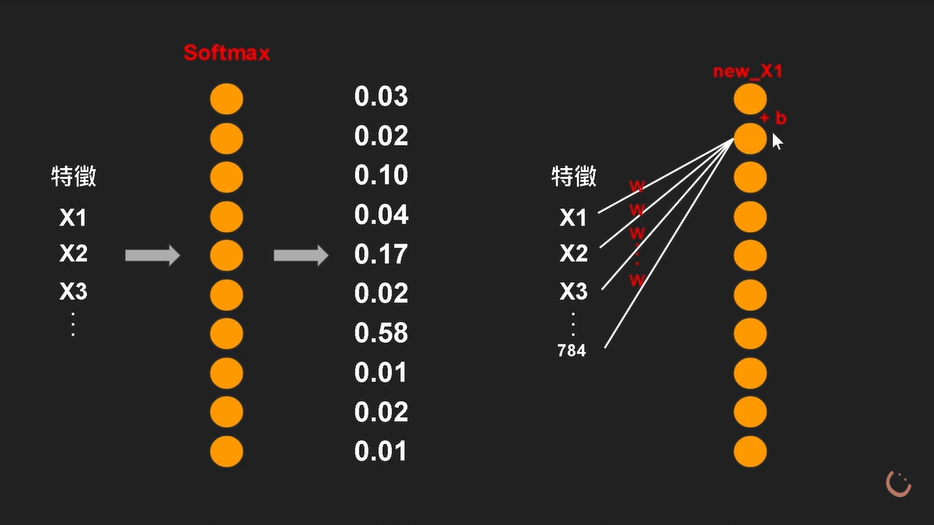
### 常見的激活函數
##### 使用激活函數的原因
如果不使用激活函數，每一層之間的變換都是線性的。即使疊加多層線性變換，最終的效果仍然是線性的。這樣的網絡無法解決實際應用中的非線性問題。
激活函數的引入打破了線性關係，使得神經網絡可以學習複雜的非線性映射，這樣它就能夠更好地擬合數據中的複雜模式。
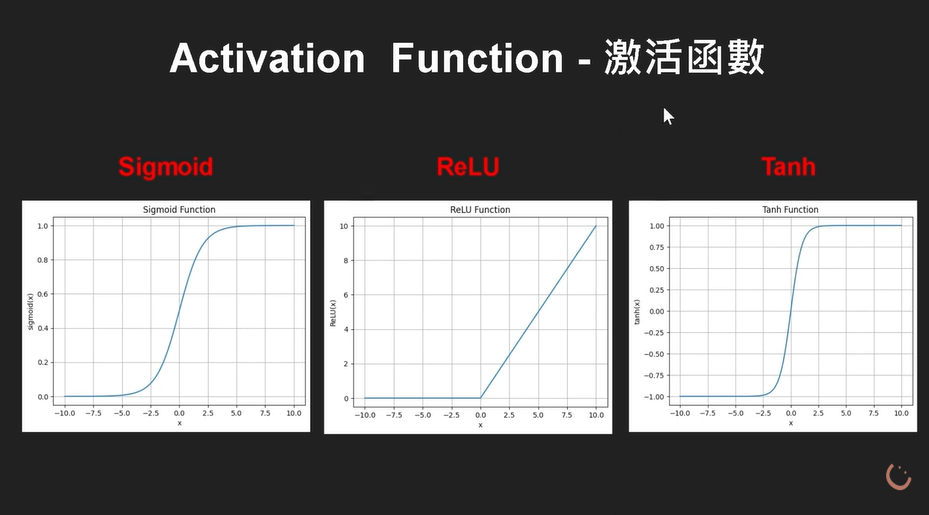
### 新架構(多層)
通常最後一層會根據期望的輸出選擇激活函數(分類問題選擇softmax)
而其他層可以預設使用Relu 因為計算速度最快
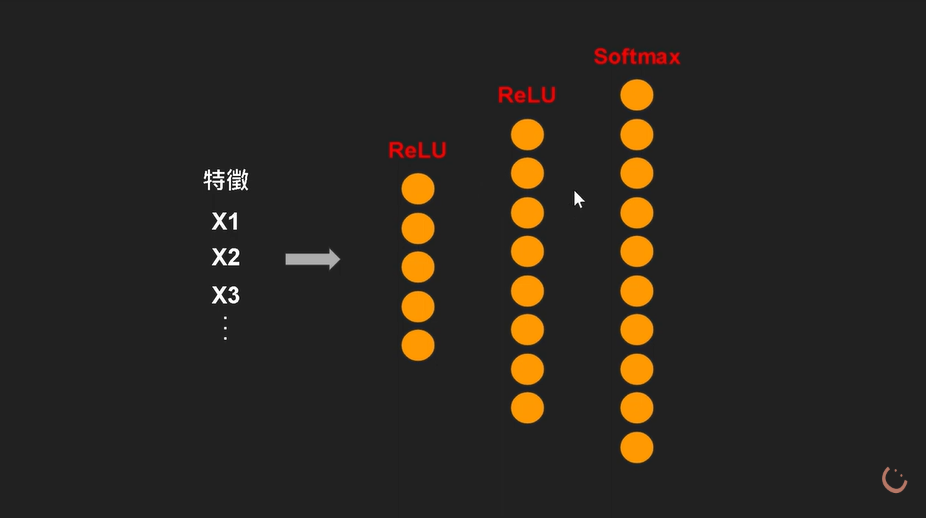

In [24]:
#根據上圖所建的新架構
class ImageClassificationModel2(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential( #用sequential把步驟串起來變成一個單位
            nn.Flatten(start_dim=1, end_dim=-1), #x_first_batch的shape是[32*1*28*28] 所以從第一個維度開始攤平
            nn.Linear(in_features=input_shape, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=output_shape)
            #nn.Softmax(dim=1) #y_pred的shape是[32,10] 要softmax的應該是第二個維度
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [25]:
#創建模型
model_2 = ImageClassificationModel2(28*28, 10)
model_2.to(device)
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [26]:
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    
    train_step(train_dataloader, model_2, cost_fn, optimizer, accuracy_fn, device)
    test_step(test_dataloader, model_2, cost_fn, accuracy_fn, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------

Train Cost: 1.4253, Train Acc: 47.88
Test Cost: 0.8108, Test Acc: 70.43

Epoch: 1
-------

Train Cost: 0.7083, Train Acc: 74.29
Test Cost: 0.6638, Test Acc: 76.01

Epoch: 2
-------

Train Cost: 0.6285, Train Acc: 77.00
Test Cost: 0.6207, Test Acc: 77.28

Epoch: 3
-------

Train Cost: 0.5914, Train Acc: 78.51
Test Cost: 0.6075, Test Acc: 77.65

Epoch: 4
-------

Train Cost: 0.5718, Train Acc: 79.22
Test Cost: 0.5751, Test Acc: 78.76

Epoch: 5
-------

Train Cost: 0.5553, Train Acc: 80.02
Test Cost: 0.5736, Test Acc: 79.05

Epoch: 6
-------

Train Cost: 0.5423, Train Acc: 80.69
Test Cost: 0.5624, Test Acc: 79.84

Epoch: 7
-------

Train Cost: 0.5289, Train Acc: 81.21
Test Cost: 0.5581, Test Acc: 79.62

Epoch: 8
-------

Train Cost: 0.5150, Train Acc: 81.71
Test Cost: 0.5297, Test Acc: 81.32

Epoch: 9
-------

Train Cost: 0.5038, Train Acc: 82.24
Test Cost: 0.5248, Test Acc: 81.78



In [30]:
#評估模型的函式
def eval_model(dataloader, model, cost_fn, accuracy_fn, device):
    test_cost = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            test_pred = model(x)
            
            test_cost += cost_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        test_cost /= len(dataloader)
        test_acc /= len(dataloader)
    
    return {
        'model name': model.__class__.__name__,
        'model_cost': test_cost.item(), #不要向量的形式 使用item()來獲得單純的數字
        'model_acc':test_acc.item()
    }

In [31]:
model_result = eval_model(test_dataloader, model, cost_fn, accuracy_fn, device)
model_result

{'model name': 'ImageClassificationModel',
 'model_cost': 0.5480602383613586,
 'model_acc': 81.49960327148438}

In [56]:
model_2_result = eval_model(test_dataloader, model_2, cost_fn, accuracy_fn, device)
model_2_result

{'model name': 'ImageClassificationModel2',
 'model_cost': 0.5248335003852844,
 'model_acc': 81.7791519165039}

In [38]:
#卷積層、最大池化層實作
conv_layer = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), stride=1, padding=1)
conv_output = conv_layer(x_first_batch[0])
print(conv_output.shape)
#in_channels代表輸入的channel數
#out_channels代表輸出的channel數 即filter數
#padding代表外面要補幾圈0
maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
maxpool(conv_output).shape

torch.Size([5, 28, 28])


torch.Size([5, 14, 14])

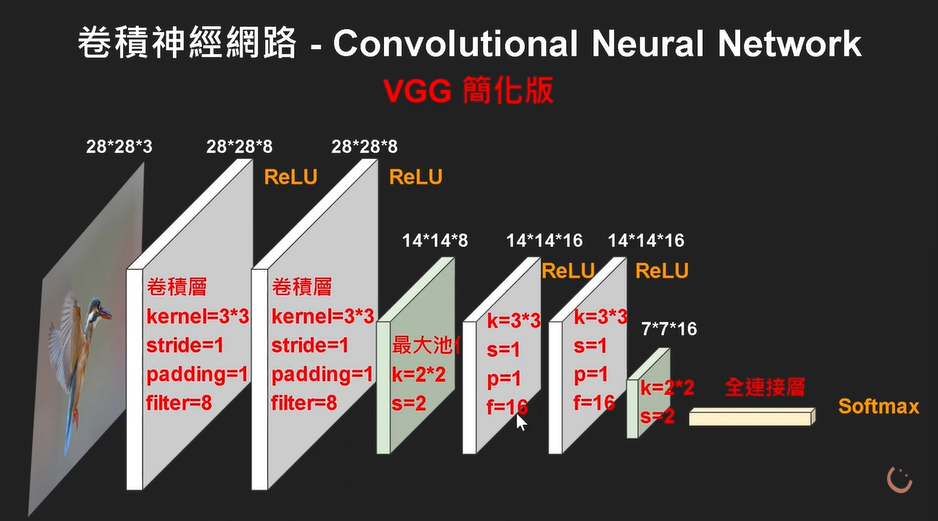

In [77]:
#根據上圖建造神經網路架構(但我們的圖片是灰階圖 所以一開始的in_channels是1)
class ImageClassificationModel3(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential( 
            nn.Conv2d(in_channels=input_shape, out_channels=8, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        )
        self.conv_block2 = nn.Sequential( 
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        )
        self.classifier = nn.Sequential( #這層不確定in_features可以先帶入一張圖片進去前兩層看輸出形狀
            nn.Flatten(start_dim=1, end_dim=-1), #預設是從第一個維度攤平到最後一個
            nn.Linear(in_features=16*7*7, out_features=output_shape),
        )
    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [78]:
model_3 = ImageClassificationModel3(1,10)
model_3.to(device)
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

In [ ]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    
    train_step(train_dataloader, model_3, cost_fn, optimizer, accuracy_fn, device)
    test_step(test_dataloader, model_3, cost_fn, accuracy_fn, device)

In [ ]:
model_3_result = eval_model(test_dataloader, model_3, cost_fn, accuracy_fn, device)
model_3_result